# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
cts = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']

In [4]:
# Pick the celltype for the celltype-specific training
ct = cts[2]; ct

'RPE'

In [5]:
xb = np.load('pred/feats_train_'+ct+'.npy')
yb = np.load('pred/targs_train_'+ct+'.npy')
xq = np.load('pred/feats_valid_'+ct+'.npy')
yq = np.load('pred/targs_valid_'+ct+'.npy')

In [6]:
xb.shape # nb-by-d

(33000, 512)

In [7]:
xq.shape # nq-by-d (query vectors)

(4428, 512)

In [8]:
yb.shape, yq.shape

((33000,), (4428,))

In [9]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 726)

In [10]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [11]:
xb.max()

65.97725

In [12]:
faiss.normalize_L2(xb)

In [13]:
xb.max()

0.40540278

In [14]:
index.train(xb)

In [15]:
index.add_with_ids(xb, yb)

In [16]:
print(index.is_trained)
print(index.ntotal)

True
33000


## Train dataset

In [17]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[1107 1107 1107 1107 1107]
 [ 715  715  715  715  715]
 [1019 1019 1019 1019 1019]
 [ 325  325  325  325  325]
 [ 228  228  228  228  228]]
[[1107]
 [ 715]
 [1019]
 [ 325]
 [ 228]]
[[0.9999999  0.9840884  0.97910523 0.97525567 0.95887357]
 [0.99999964 0.9869476  0.9543823  0.9190498  0.91578317]
 [1.         0.9986981  0.99780595 0.9942547  0.9936279 ]
 [0.99999976 0.9931025  0.98719233 0.98662716 0.9856464 ]
 [0.9999999  0.97825134 0.97796726 0.9759308  0.9752014 ]]


In [18]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [19]:
I_train[:,0].shape, yb.shape

((33000,), (33000,))

In [20]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [21]:
I_train[:10,0], yb[:10]

(array([1107,  715, 1019,  325,  228,  604, 1049, 1085,  838,  305]),
 array([1107,  715, 1019,  325,  228,  604, 1049, 1085,  838,  305]))

In [22]:
I_train[-10:,0], yb[-10:]

(array([ 647,   30, 1076,  427,  704,  706, 1097, 1044,  744,  340]),
 array([ 647,   30, 1076,  427,  704,  706, 1097, 1044,  744,  340]))

### Train confusion matrix

In [23]:
#cm = confusion_matrix(I_train[:,0], yb)

In [24]:
#fig, ax = plt.subplots(figsize=(15,15))
#ax.matshow(cm, cmap='hot')

## Valid dataset

In [25]:
xq.max()

62.35074

In [26]:
faiss.normalize_L2(xq)

In [27]:
xq.max()

0.4597521

In [28]:
D_valid, I_valid = index.search(xq, k) # actual search

In [29]:
xq.shape, yq.shape

((4428, 512), (4428,))

In [30]:
I_valid.shape, D_valid.shape

((4428, 5), (4428, 5))

In [31]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[ 970  970  970  970  970]
 [1099 1099 1099 1099 1099]
 [ 185  185  185  185  185]
 [ 969  969  969  969  969]
 [1068  432 1068 1068 1068]]
[[ 866]
 [1099]
 [ 860]
 [ 369]
 [ 432]]
[[0.5077799  0.50113773 0.49988544 0.49454075 0.49296078]
 [0.7565801  0.7472006  0.74373114 0.7383687  0.7366747 ]
 [0.60507375 0.604153   0.5953627  0.5861     0.5819129 ]
 [0.6571206  0.65101546 0.6427763  0.63388    0.6255032 ]
 [0.7492731  0.7006339  0.6987406  0.6956297  0.67812735]]


In [32]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[976 226 976 976 226]
 [321 321 321 321 321]
 [911 911 911 911 911]
 [231 231 231 231 231]
 [328 328 328 328 328]]
[[573]
 [899]
 [531]
 [231]
 [328]]
[[0.62864566 0.6204872  0.61425567 0.6099805  0.6081822 ]
 [0.64057446 0.6327471  0.6035048  0.59396505 0.58042747]
 [0.601558   0.56942874 0.5635555  0.54547644 0.528593  ]
 [0.99586076 0.9950345  0.9945512  0.99419606 0.99416375]
 [0.7027962  0.70193064 0.67662245 0.67604816 0.6736376 ]]


In [33]:
np.save('pred/preds_valid_'+ct+'.npy', I_valid)

### Valid accuracy

In [34]:
I_valid[:,0]

array([ 970, 1099,  185, ...,  911,  231,  328])

In [35]:
yq

array([ 866, 1099,  860, ...,  531,  231,  328])

In [36]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

2496

In [37]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.5636856368563685

In [38]:
valid_correct = np.equal(I_valid[:,0], yq)

In [39]:
valid_correct

array([False,  True, False, ..., False,  True,  True])

In [40]:
np.save('pred/preds_valid_correct_'+ct+'.npy', valid_correct)

### Valid confusion matrix

In [41]:
cm = confusion_matrix(I_valid[:,0], yq)

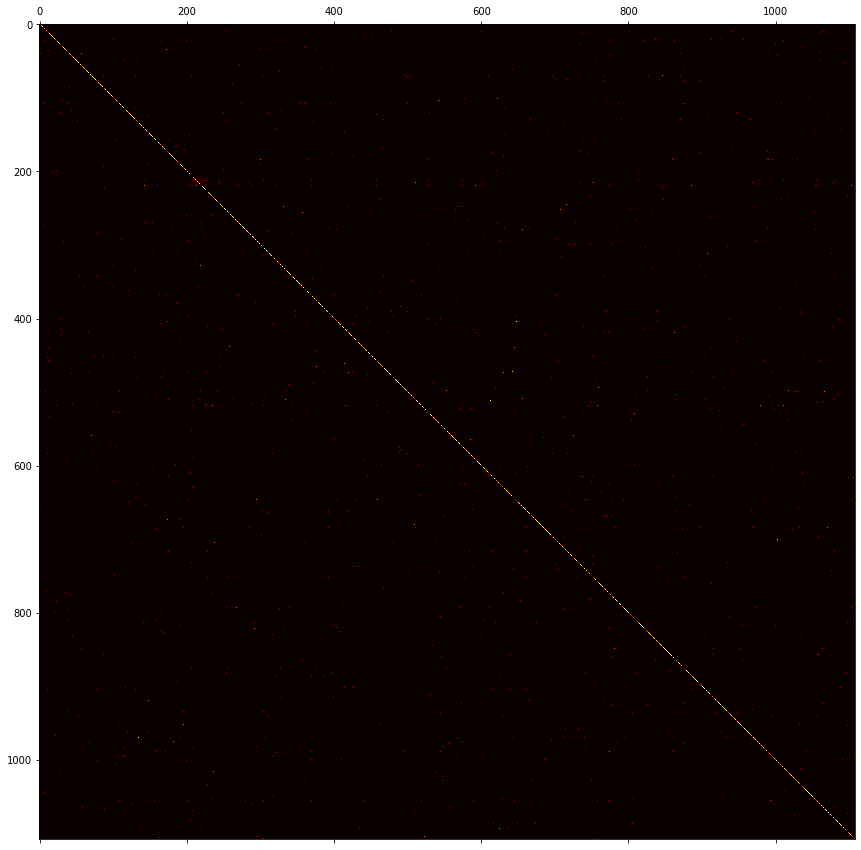

In [42]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

9690

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

5786

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.6261307831481003

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [43]:
xq_test = np.load('pred/feats_test_'+ct+'.npy')

In [44]:
xq_test.max()

58.78212

In [45]:
faiss.normalize_L2(xq_test)

In [46]:
xq_test.max()

0.44840837

In [47]:
D_test, I_test = index.search(xq_test, k) # actual search

In [48]:
xq_test.shape, I_test.shape, D_test.shape

((8834, 512), (8834, 5), (8834, 5))

In [49]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[629 629 629 629 629]
 [289 289 289 289 289]
 [  4   4   4   4   4]
 [648 648 648 648 648]
 [848 848 848 848 848]]
[[0.700251   0.671379   0.6713295  0.67095613 0.6689906 ]
 [0.69194645 0.67707324 0.6644672  0.65743667 0.6511539 ]
 [0.99639046 0.99589837 0.99583834 0.9955965  0.9954165 ]
 [0.82153296 0.81992126 0.81968    0.8133295  0.81178   ]
 [0.53845954 0.5294601  0.5281557  0.5273684  0.5188447 ]]


In [50]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[261 261 261 261 261]
 [493 493 493 493 493]
 [ 82  82  82  82  82]
 [688 688 688 688  50]
 [817 817 817 817 817]]
[[0.7177961  0.7096745  0.6970068  0.69600785 0.6930543 ]
 [0.9973007  0.9972925  0.99705833 0.99659437 0.9965059 ]
 [0.79000294 0.7890316  0.7882626  0.7804351  0.77935064]
 [0.47168493 0.43402582 0.41721386 0.41252396 0.4059686 ]
 [0.9111052  0.9081876  0.90523195 0.90183175 0.9005139 ]]


In [51]:
I_test[2]

array([4, 4, 4, 4, 4])

In [52]:
np.unique(I_test[2], return_counts=True)

(array([4]), array([5]))

In [53]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [54]:
np.save('pred/preds_test_'+ct+'.npy', preds_test)
np.save('pred/dist_test_'+ct+'.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)